<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT21/blob/YinengWang/Lab_4/Lab4_YinengWang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Approximation**
**Yineng Wang**

# **Abstract**

This report includes the implementation and test for l2 projection.

#**About the code**

This report is written by Yineng Wang, based on Johan Hoffman's template.

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell.

In [2]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

# **Introduction**

The L2 projection is a method of approximation by projection in the subspace $V_N \subset V$. By equation (9.12), the L2 projection $P_N f \in V_N$ of a function $f \in V$ to a finite dimensional subspace $V_N$ is defined as

$$
(P_N f, v) = (f, v), \quad \forall v \in V_N,
$$

where the inner product of the Hilbert space $L^2([a, b])$ is defined as

$$
(f, g) = \int_a^b f(x)g(x) dx.
$$

By equation (9.13), this is equivalent to find a set of constants $\alpha_i$, $i = 1, \dots, N$ such that

$$
\sum_{j=1}^N \alpha_j (\phi_j, \phi_i) = (f, \phi_i), \quad i = 1, \dots, N,
$$

where $\{\phi_i\}_{i=1}^N$ is a basis of $V_N$. This can be presented as a linear system of equations
$A \alpha = b$
where $a_{ij} = (\phi_j, \phi_i) = \int_a^b \phi_j(x) \phi_i(x) dx$ and $b_i = (f, \phi_i) = \int_a^b f(x) \phi_i(x) dx$.

# **Method**

## 1. L2 projection to pw linear approximation over mesh in 1D

Input: function f(x), 1D mesh with nodes (x0,...,xn)

Output: vector of L2 projection of f(x) evaluated in (x0,...,xn) 

We use algorithm (9.2), the assembly algorithm, to generate the linear system. The basis functions as equation (9.8) construct a basis for $V_h^{(1)}$. According to equation (9.17), (9.18), (9.19), the non-zero matrix entries are $a_{ii} = h_i/3 + h_{i+1}/3$, $a_{i,i+1} = h_{i+1}/6$ and $a_{i,i-1} = h_i/6$. By using the assembly algorithm, the local matrix entries (indexed from 0) are

$$
\begin{align*}
a_{00}^{(k)} &= \int_{x_k}^{x_{k+1}} \left(\frac{x_{k+1}-x}{h_k}\right)^2 dx = \frac{h_k}{3}, \\
a_{01}^{(k)} &= a_{10}^{(k)} = \int_{x_k}^{x_{k+1}} \frac{x_{k+1}-x}{h_k} \frac{x-x_{k}}{h_k} dx = \frac{h_k}{6}, \\
a_{11}^{(k)} &= \int_{x_k}^{x_{k+1}} \left(\frac{x-x_{k}}{h_k}\right)^2 dx = \frac{h_k}{3}.
\end{align*}
$$

To compute the inner product $(f, \phi_i)$, we use `scipy.integrate.quad`.

The L2 projection of $f(x)$ evaluated on $(x_0, \dots, x_n)$ is exactly the vector $(\alpha_0, \dots, \alpha_n)$, since $\phi_i(x_i) = 1$ and $\phi_j(x_i) = 0$ if $i \neq j$.

In [3]:
def assembly_algorithm(f, x):
    def integrate_vector(f, k, i):
        a, b = x[k], x[k+1]
        def f_lambda_0(x):
            return f(x) * (b-x) / (b-a)    # f(x) * lambda_k,0(x)
        def f_lambda_1(x):
            return f(x) * (x-a) / (b-a)    # f(y) * lambda_k,1(y)
        if i == 0:
            return scipy.integrate.quad(f_lambda_0, a, b)[0]
        else:
            return scipy.integrate.quad(f_lambda_1, a, b)[0]

    def integrate_matrix(k, i, j):
        h = x[k+1]-x[k]
        return h/3 if i == j else h/6

    q = 1
    n = len(x)
    A = np.zeros((n, n))
    b = np.zeros(n)

    for k in range(n-1):
        local_A = np.zeros((q+1, q+1))
        local_b = np.zeros(q+1)
        for i in range(q+1):
            local_b[i] = integrate_vector(f, k, i)
            for j in range(q+1):
                local_A[i,j] = integrate_matrix(k, i, j)
        A[k:k+2, k:k+2] += local_A
        b[k:k+2] += local_b
    return A, b

def l2_projection(f, x):
    n = len(x)
    A, b = assembly_algorithm(f, x)
    alpha = np.linalg.solve(A, b)
    return alpha

# **Results**

We use the trigonometric function $f(x) = \sin(x), x \in [-\pi, \pi)$ to test the implementation. The mesh has uniform length 0.1.

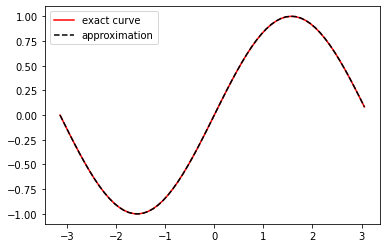

In [4]:
def verify_l2_projection():
    mesh = np.arange(-np.pi, np.pi, 0.1)
    approx = l2_projection(np.sin, mesh)
    exact = np.sin(mesh)
    l1, = plt.plot(mesh, exact, color='red')
    l2, = plt.plot(mesh, approx, '--', color='black')
    plt.legend(handles=[l1,l2], labels=['exact curve', 'approximation'], loc='best')
    plt.show()


if __name__ == '__main__':
    verify_l2_projection()

# **Discussion**

The curve shows the approximation is close to the exact function value. In solving the equation $A\alpha = b$, there can be some improvement since $A$ is sparse if we use the basis function $\{\phi_i\}_{i=0}^j$ of $V_h^{(1)}$. Specially, the Hessenberg QR factorization may be employed.